___
# **Starter code for BME 5710 project**
## Instructor -- Rizwan Ahmad (ahmad.46@osu.edu)
## BME5710 -- Spring 2024

___
### Import libraries and sub-libraries.

In [2]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
import tifffile 

___
### Calling a custom code to change the default font for figures to `Computer Modern`. (Optional)

In [3]:
# from fontsetting import font_cmu
# plt = font_cmu(plt)

___
### Check the hardware that is at your disposal

In [4]:
device = torch.device('gpu' if torch.cuda.is_available() else 'cpu')
print('Device available:', device)

Device available: cpu


___
### Read training data from `data/train-clean-tif`


In [5]:
# Loading TIFF images
class TIFFDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.filenames = [f for f in os.listdir(directory) if f.endswith('.tif')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.filenames[idx])
        image = Image.open(img_path)
        if self.transform: # Dynamically apply data transformation
            image = self.transform(image)
        return image

# Create a transform to convert the images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dataset for training images
train_dataset = TIFFDataset('train-clean-tif', transform=transform)

# Function to create data loader
def create_loader(train_dataset, batch_size):
    torch.manual_seed(0)  # For reproducibility of random numbers in PyTorch
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Creates a training DataLoader from this Dataset
    return train_loader

dataset_size = len(train_dataset)
print('Number of images in the dataset:', dataset_size)


Number of images in the dataset: 52


___
### Define a denoising network

#### Here, I have defined a trivial network, which has only one convolutional layer and no activation function. We are essentially doing linear filtering.

In [6]:
class TrivialNet(nn.Module):
    def __init__(self):
        super(TrivialNet, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv(x)
        return x

___
### Create a function to execute training. Note, we will call this function later.

In [7]:
def train_model(model, opt, criterion, train_loader, num_epoch, noise_std):
    avg_train_losses = []

    for epoch in range(num_epoch): # Loop over the dataset multiple times
        model.train()
        total_train_loss = 0
        for i, y_tr_batch in enumerate(train_loader): # Loop over mini-batches
            noise = torch.randn_like(y_tr_batch) * noise_std
            x_tr_batch = y_tr_batch + noise

            opt.zero_grad() # delete previous gradients
            y_hat_tr_batch = model(x_tr_batch) # forward pass
            loss = criterion(y_hat_tr_batch, y_tr_batch) # compute loss
            loss.backward() # backward pass
            opt.step() # update weights
            total_train_loss += loss.item() # accumulate loss
            if (i + 1) % 10 == 0:
                print(f'Epoch {epoch+1}, Iteration {i+1}, Loss: {loss.item():.6f}')

        avg_train_loss = total_train_loss / len(train_loader) # compute average loss
        avg_train_losses.append(avg_train_loss) # accumulate average loss

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(range(1, num_epoch+1), avg_train_losses, label='training loss')
    ax.set_xlabel('epochs')
    ax.set_ylabel('MSE loss')
    ax.set_yscale('log')  # Set the vertical axis to log scale
    ax.set_title('training loss')
    ax.grid(True)
    ax.legend()
    plt.show()

___
### Now, let us define hyperparameters and train the network. 

#### Note, in addition to the parameters that controls the network architecture or the training process, you need to select/initialize (i) a data loader, (ii) a model, (iii) an optimizer, and (iv) a loss function.

Epoch 1, Iteration 10, Loss: 0.039564
Epoch 1, Iteration 20, Loss: 0.037425
Epoch 2, Iteration 10, Loss: 0.021627
Epoch 2, Iteration 20, Loss: 0.018851
Epoch 3, Iteration 10, Loss: 0.014599
Epoch 3, Iteration 20, Loss: 0.014679
Epoch 4, Iteration 10, Loss: 0.012949
Epoch 4, Iteration 20, Loss: 0.012118
Epoch 5, Iteration 10, Loss: 0.011824
Epoch 5, Iteration 20, Loss: 0.009488
Epoch 6, Iteration 10, Loss: 0.008899
Epoch 6, Iteration 20, Loss: 0.008933
Epoch 7, Iteration 10, Loss: 0.008545
Epoch 7, Iteration 20, Loss: 0.007196
Epoch 8, Iteration 10, Loss: 0.007116
Epoch 8, Iteration 20, Loss: 0.006958
Epoch 9, Iteration 10, Loss: 0.006033
Epoch 9, Iteration 20, Loss: 0.005523
Epoch 10, Iteration 10, Loss: 0.005139
Epoch 10, Iteration 20, Loss: 0.005174
Epoch 11, Iteration 10, Loss: 0.005585
Epoch 11, Iteration 20, Loss: 0.004835
Epoch 12, Iteration 10, Loss: 0.004644
Epoch 12, Iteration 20, Loss: 0.004253
Epoch 13, Iteration 10, Loss: 0.004388
Epoch 13, Iteration 20, Loss: 0.004451
Epoc

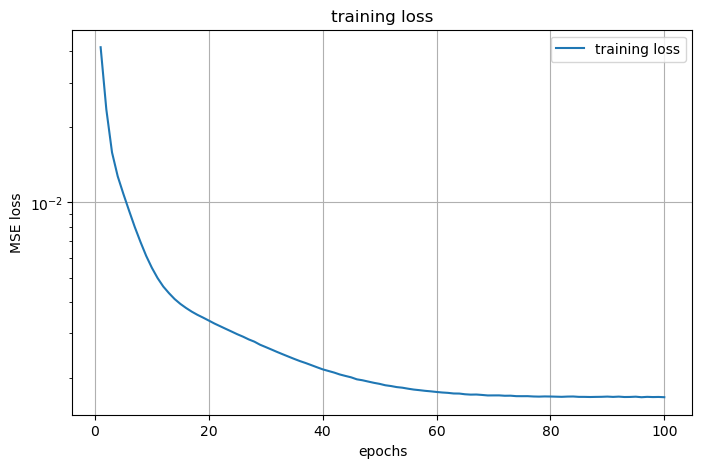

In [8]:
batch_size = 2  # Number of complete images in each batch
lr = 1e-3  # Learning rate
sig = 0.1  # Noise std
num_epoch = 100  # Epochs

# Model, criterion, and optimizer
train_loader = create_loader(train_dataset, batch_size)
model = TrivialNet() # Pick a model
opt = optim.Adam(model.parameters(), lr=lr) # Pick an optimizer
criterion = nn.MSELoss() # Pick a loss function

# Let's train the model
train_model(model, opt, criterion, train_loader, num_epoch, noise_std=sig)

___
### Apply it to one of the validation image

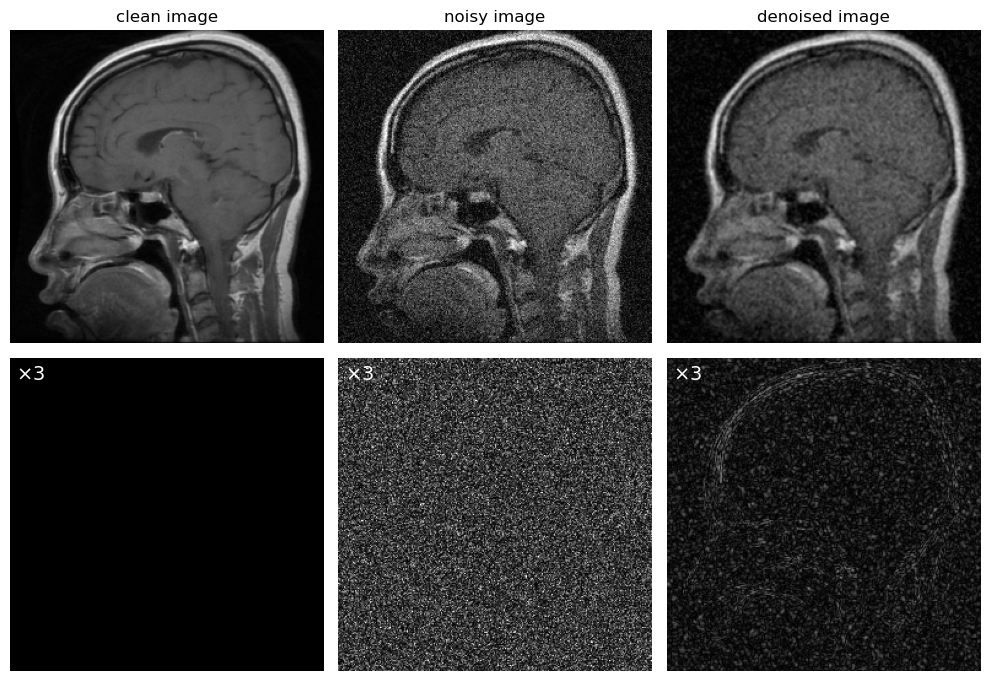

In [9]:
val_dataset = TIFFDataset('val-clean-tif', transform=transform) # Create the dataset for validation images
val_clean = val_dataset[0] # Load one clean image from the validation dataset
val_noisy = val_clean + (torch.randn_like(val_clean) * sig) # Add noise to the clean image
val_denoised = model(val_noisy).detach() # Denoise the noisy image using the trained model


# Your existing code to generate the figure and axes
fig, ax = plt.subplots(2, 3, figsize=(10, 7))

# Plot clean image
ax[0, 0].imshow(np.abs(val_clean).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 0].set_title('clean image')
ax[0, 0].axis('off')

# Plot noisy image
ax[0, 1].imshow(np.abs(val_noisy).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 1].set_title('noisy image')
ax[0, 1].axis('off')

# Plot denoised image
ax[0, 2].imshow(np.abs(val_denoised).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 2].set_title('denoised image')
ax[0, 2].axis('off')

# Plot corresponding error images
ax[1, 0].imshow(3*np.abs(val_clean - val_clean).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 0].axis('off')
ax[1, 0].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 0].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 1].imshow(3*np.abs(val_clean - val_noisy).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 1].axis('off')
ax[1, 1].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 1].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 2].imshow(3*np.abs(val_clean - val_denoised).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 2].axis('off')
ax[1, 2].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 2].transAxes, fontsize=14, va='top', ha='left', color='white')


plt.tight_layout()
plt.show()


### Calculating NMSE and SSIM

In [29]:
from skimage.metrics import structural_similarity as ssim

def calculateNMSE(im_denoised,im_clean):
    num = torch.sqrt(torch.sum((im_denoised-im_clean)**2))
    denom = torch.sqrt(torch.sum(im_clean**2))
    NMSE = 20*torch.log10(num/denom)
    return NMSE

# def calculatNMSE(im_denoised,im_clean):
#     num = torch.norm(im_denoised-im_clean)
#     denom = torch.norm(im_clean)
#     NMSE_2 = 20*torch.log10(num/denom)
#     return NMSE_2

NMSE_val = calculateNMSE(val_denoised,val_clean)
print(f'NMSE: {NMSE_val:0.5f}')

def calculateSSIM(im_clean, im_denoised):

    im_clean = np.abs(im_clean.detach()).squeeze().numpy()
    im_denoised = np.abs(im_denoised.detach()).squeeze().numpy()
    im_range = np.max(im_clean) - np.min(im_clean)

    return ssim(im_clean, im_denoised, data_range=im_range)

SSIM = calculateSSIM(val_clean,val_denoised)
print(f'SSIM: {SSIM:0.5f}')

NMSE: -17.43229
SSIM: 0.70175
